<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/cv04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. cvičenie - Plne prepojená sieť v PyTorchi

V tomto notebooku si vyskúšame trénovanie plne prepojenej neurónovej siete. Pri práci budeme používať framework PyTorch, ktorého dokumentáciu nájdete na https://pytorch.org/docs/stable/index.html

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt

Budeme pracovať s jednoduchým datasetom MNIST, ktorý obsahuje obrázky čísel, ktoré sa vypĺňajú do PSČ políčok.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

x_np = np.asarray(mnist.data).astype('float32')/255
labels_np = np.asarray(mnist.target).astype('int64')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset si môžeme zobraziť.

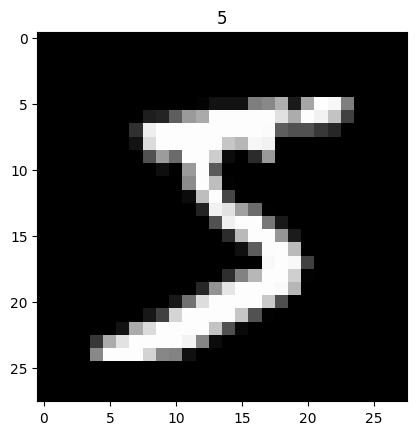

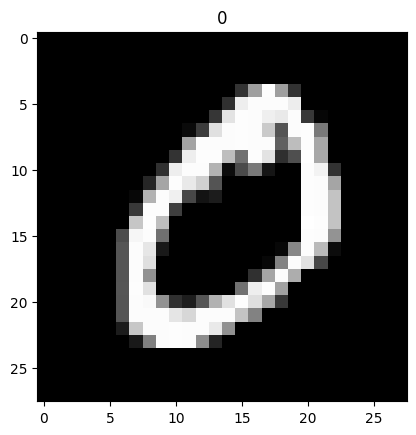

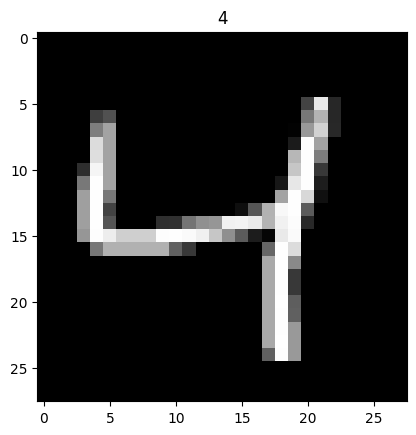

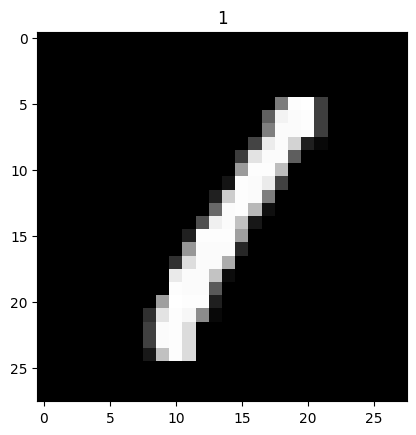

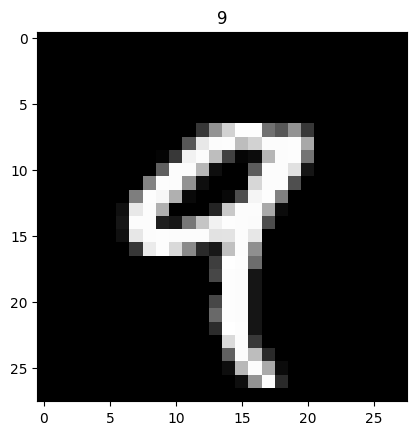

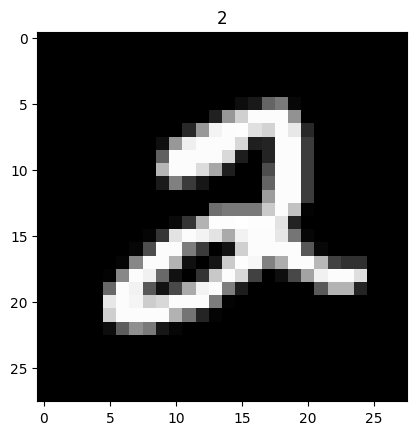

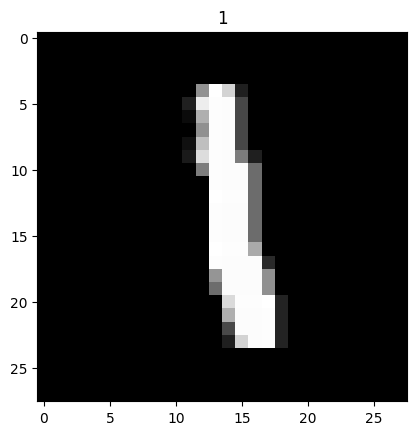

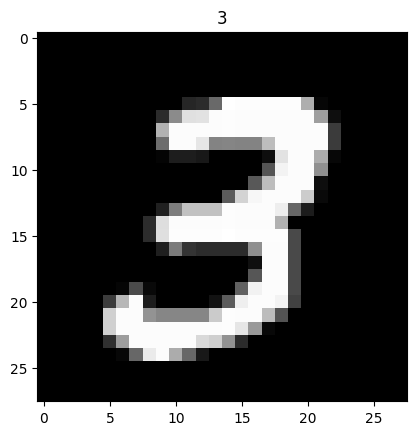

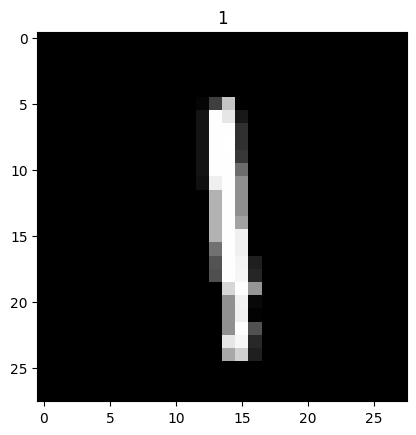

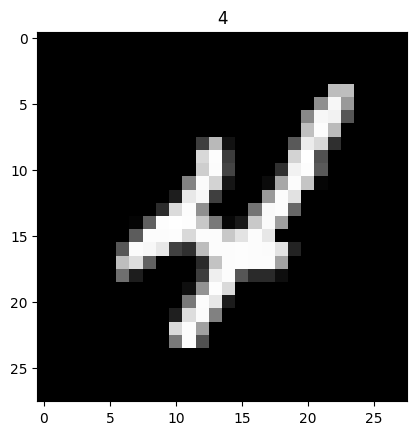

In [ ]:
for i in range(10):
  plt.imshow(np.reshape(x_np[i,],(28,28)), cmap='gray')
  plt.title(labels_np[i])
  plt.show()

## One-hot encoding

Doteraz sme pracovali iba s dvoma triedami. V takom prípade bola reprezentácia relatívne jednoduchá. Avšak pri viac triedach je nutné zvoliť vhodný spôsob ako tieto triedy reprezentovať. Dalo by sa to napr. jedným celým číslom pre každu triedu a to by sieť mala vyhodiť. Avšak to je problém, lebo napr. ak máme tri kategórie: mačka (0), pes (1), škrečok (2), tak by sa sieť v podstate musela naučiť reprezentáciu v ktorej platí, že priemer mačky a škrečka je pes, lebo (0 + 2) / 2 = 1. Toto nedáva zmysel. Preto bude lepšie ak sieť bude na výstupe mať napr. vektor s rovnakou dĺžkou ako počet tried a každý prvok bude určovať pravdepodobnosť danej triedy. Pri anotovaných dátach presne vieme, že len jedna kategória má pravdebodobnosť jedna a ostatné nula, takže bude vyzerať asi takto $(0, 0, 0, 1, 0, 0)$. Takáto reprezentácia sa volá one-hot encoding. Na konverziu labelov, môžeme použiť pytorchovskú funkciu onehot.

Keďže ďalej budeme pracovať s tenzormy, tak si prekonvertujeme aj naše vstupné dáta na torch Tensory pomocou torch.from_numpy(). Funkcia one_hot urobí konverziu automaticky.

In [ ]:
from torch.nn.functional import one_hot

x = torch.from_numpy(x_np)

y = one_hot(torch.from_numpy(labels_np))

labels = torch.from_numpy(labels_np)

for i in range(10):
  print("labels: ", labels[i])
  print("one-hot: ", y[i])

labels:  tensor(5)
one-hot:  tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
labels:  tensor(0)
one-hot:  tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(4)
one-hot:  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(9)
one-hot:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
labels:  tensor(2)
one-hot:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(3)
one-hot:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(4)
one-hot:  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


## Model plne prepojenej siete

Najprv si teda vytvoríme model. Náš model nebude využívať komplikované prepojenia, takže môžeme použiť torch.nn.Sequential. Čo je konštruktor pre sieť v ktorej výstup z jednej vrstvy je vstupom iba do ďalšej atď.

Ako jednotlivý prvky v modeli budú jeho vrstvy. Tu použijeme plne prepojené vrstvy, ktoré sa v kerase dajú nájsť pod torch.nn.Linear. Podobne budeme podtrebovať aj aktivačné funkcie napr. torch.nn.ReLU. Jednolivé plneprepojené vrstvy sa inicializujú s argumentmi s počtom vstupných a výstupných neurónov. V prvej vrstve teda potrebujeme 28 * 28 neurónov (rovnako ako v obrázku) a na výstupe 10 podľa počtu tried.

### Stratová funkcia

Ako stratovú funkciu použijeme tzv. categorical crossentropy. Tá má tvar

$$L(\vec{y}, \hat{\vec{y}}) = - \sum_{i=1}^n \hat{y}_i \text{log}(\vec{y}),$$

kde $\vec{y}$ je výstup siete a $\hat{\vec{y}}$ sú one-hot anotácie. Na to aby to fungovalo, tak predpokladáme, že posledná vrstva je tzv. softmax, ktorá aplikuje funkciu $\mathbb{R}^n \mapsto \mathbb{R}^n$ a pre vstupný vektor má jej $i$-tá zložka tvar:

$$\text{softmax}(\vec{z})_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}.$$

Táto vrstva teda akosi normalizuje výstupy siete tak, aby sme ich mohli interpretovať ako pravdepodobnosti, keďže jej výsupy sa dajú sčítať na 1. Problémom je, že táto vrstva robí operáciu exp, ale v stratovej funkcii zas robíme log. Ak aplikujeme exp na nejaké veľké číslo môžeme dostať NaN a následny logaritmus bude tiež nan, aj keď plátí že:

$$ \text{log}(e^X) = X,$$

teda sa dá NaNu vyhnúť. Preto budeme mať dva modely jeden bude pre trénovanie a rovno sa v ňom spočíta loss zo vstupov do softmaxu a v druhom sa aplikuje len softmax.

Ako loss teda môžeme použiť `torch.nn.CrossEntropyLoss`.


### Optimalizácia

V minulosti sme používali optimalizáciu, ktorú sme si vyrobili ručne. Torch však ponúka aj túto funkcionalitu rovno naimplementovanú. Rôzne optimalizačné postupy sú k dispozícii v torch.optim

Zatiaľ použijeme torch.optim.SGD. Tomuto objektu ale treba aj dať vedieť, čo sú parametre modelu. Tie získame z už konštruovaného modelu.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax
model = Sequential(Linear(28 * 28, 30),
                   ReLU(),
                   Linear(30, 20),
                   ReLU(),
                   Linear(20, 10))

model_inference = Sequential(model, Softmax(dim=-1))

Model môžeme aplikovať na vstupné dáta. Pritom sa však očakáva, že vstup bude veľkosti $n \times (28*28)$. V jednoduchom prípade sieť zvládne aj vstup veľkosti $28 * 28$, ale netreba s tým rátať aj pri iných sieťach.

In [ ]:
print(model_inference(x[:3]))
print(model_inference(x[0]))
print(model_inference(x[None, 0]))

print(model(x[:3]))
print(model(x[0]))
print(model(x[None, 0]))


tensor([[0.0808, 0.0854, 0.1019, 0.1267, 0.1021, 0.0882, 0.1071, 0.1247, 0.0845,
         0.0986],
        [0.0842, 0.0868, 0.1028, 0.1276, 0.1021, 0.0816, 0.1012, 0.1211, 0.0860,
         0.1066],
        [0.0808, 0.0864, 0.1005, 0.1246, 0.1039, 0.0875, 0.1051, 0.1252, 0.0866,
         0.0992]], grad_fn=<SoftmaxBackward0>)
tensor([0.0808, 0.0854, 0.1019, 0.1267, 0.1021, 0.0882, 0.1071, 0.1247, 0.0845,
        0.0986], grad_fn=<SoftmaxBackward0>)
tensor([[0.0808, 0.0854, 0.1019, 0.1267, 0.1021, 0.0882, 0.1071, 0.1247, 0.0845,
         0.0986]], grad_fn=<SoftmaxBackward0>)
tensor([[-0.2386, -0.1836, -0.0073,  0.2107, -0.0053, -0.1515,  0.0425,  0.1949,
         -0.1949, -0.0399],
        [-0.2062, -0.1756, -0.0060,  0.2098, -0.0136, -0.2371, -0.0221,  0.1575,
         -0.1847,  0.0298],
        [-0.2383, -0.1721, -0.0206,  0.1946,  0.0127, -0.1586,  0.0241,  0.1992,
         -0.1692, -0.0335]], grad_fn=<AddmmBackward0>)
tensor([-0.2386, -0.1836, -0.0073,  0.2107, -0.0053, -0.1515,  0.04

## Predbežné testovanie modelu

Pri trénovaní modelu je nutné overiť si, že má dostatočnú kapacitu pre daný problém. Kapacita modelu je v tomto prípade vyjadrenie toho akú veľkú (resp. ako zložitú) množinu funkcií je možné modelovať. Ak náš model ani teoreticky nedokáže modelovať žiadanú funkciu (napr. klasifikátor), tak nieje vhodné ho použiť. Napr. používať lineárny klasifikátor na dáta o ktorých vieme, že sú lineárne neseparovateľné je príklad nedostatočnej kapacity modelu.

Najjednoduchšie ako toto budeme testovať je tak, že vyberieme veľmi malú časť (napr. 1 minibatch) dát na ktorých chceme trénovať a overíme, či sa nám podarí model natrénovať na 100 percent na takejto malej vzorke.

Týmto testovaním tiež overíme, že trénovanie funguje a nieje problém s dátami. Tento postup je vhodný prvý krok pri troubleshootingu sietí.

*Pozn.:* Pri takomto testovaní je dôležité nemať všetky príklady z rovnakej kategórie, lebo v takom prípade ani netreba uvažovať o kapacite modelu.


In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()
x_mini = x[:32]
labels_mini = labels[:32]

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for i in range(500):
  optimizer.zero_grad()

  out = model(x_mini)
  loss = ce_loss(out, labels_mini)
  loss.backward()
  optimizer.step()

  print("Loss at step {}: {}".format(i, loss.item()))

  out = model(x_mini)
  out_classes = torch.argmax(out, dim=-1)
  acc = torch.sum(out_classes == labels_mini)/32
  print("Acc: ", acc.item())

Loss at step 0: 2.305643320083618
Acc:  0.21875
Loss at step 1: 2.2988030910491943
Acc:  0.21875
Loss at step 2: 2.292832374572754
Acc:  0.21875
Loss at step 3: 2.28690242767334
Acc:  0.21875
Loss at step 4: 2.2812581062316895
Acc:  0.21875
Loss at step 5: 2.2758562564849854
Acc:  0.21875
Loss at step 6: 2.2703957557678223
Acc:  0.1875
Loss at step 7: 2.2647414207458496
Acc:  0.1875
Loss at step 8: 2.25860333442688
Acc:  0.1875
Loss at step 9: 2.251828908920288
Acc:  0.15625
Loss at step 10: 2.2447896003723145
Acc:  0.1875
Loss at step 11: 2.2373926639556885
Acc:  0.1875
Loss at step 12: 2.2299275398254395
Acc:  0.1875
Loss at step 13: 2.222323417663574
Acc:  0.1875
Loss at step 14: 2.2143642902374268
Acc:  0.21875
Loss at step 15: 2.206098794937134
Acc:  0.28125
Loss at step 16: 2.197559356689453
Acc:  0.25
Loss at step 17: 2.188631534576416
Acc:  0.28125
Loss at step 18: 2.1789894104003906
Acc:  0.28125
Loss at step 19: 2.169156789779663
Acc:  0.28125
Loss at step 20: 2.1589238643646

Ak si vytvoríme model ktorý nemá dostatočnú kapacitu. Napr. ak použijeme sieť, ktorá ma na skrytej vrstve len jeden neurón, tak sa nebude sieť vedieť naučiť na 100 percentnú presnosť ani na malej vzorke dát.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax
model = Sequential(Linear(28 * 28, 1), ReLU(), Linear(1, 10))
model_inference = Sequential(model, Softmax(dim=-1))

ce_loss = torch.nn.CrossEntropyLoss()
x_mini = x[:32]
labels_mini = labels[:32]

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for i in range(10000):
  optimizer.zero_grad()

  out = model(x_mini)
  loss = ce_loss(out, labels_mini)
  loss.backward()
  optimizer.step()

  if i % 1000 == 999:
    print("Loss at step {}: {}".format(i, loss.item()))
    out = model_inference(x_mini)
    out_classes = torch.argmax(out, dim=-1)
    acc = torch.sum(out_classes == labels_mini)/32
    print("Acc: ", acc.item())

Loss at step 999: 1.6728463172912598
Acc:  0.4375
Loss at step 1999: 1.518486738204956
Acc:  0.46875
Loss at step 2999: 1.432634949684143
Acc:  0.46875
Loss at step 3999: 1.369325041770935
Acc:  0.46875
Loss at step 4999: 1.3121031522750854
Acc:  0.46875
Loss at step 5999: 1.2597922086715698
Acc:  0.5625
Loss at step 6999: 1.2119505405426025
Acc:  0.5625
Loss at step 7999: 1.1680024862289429
Acc:  0.5625
Loss at step 8999: 1.1284631490707397
Acc:  0.5625
Loss at step 9999: 1.0935981273651123
Acc:  0.5625


## train/val/test

Pri ďalšej práci s kapacitou modelu budeme potrebovať vymedziť tzv. split našich dát. Tento split robíme preto aby sme vedeli verifikovať, či náš model naozaj dokáže dosahovať dobré výsledky na dátach ktoré neboli použíté na trénovanie.

Dáta ktoré model nevidel budeme označovať ako testovacie. Tieto dáta používame len na overenie výsledkov.

Ostali nám teda dáta na trénovanie. Problém ale je, že máme dva druhy optimalizácie. Jednou optimalizáciou (napr. SGD) vyberáme samotné parametre modelu. Druhú optimalizáciu robíme ako uživatelia a to tým, že vyberáme optimalizačný algoritmus pre prvý druh optimalizácie. Takisto vyberáme aj parametre tejto optimalizácie a iné veci ako napríklad samotný výber architektúry modelu, inicializačný algoritmus, veľkosť minibatch, dĺžku trénovania atď. Tieto veci častokrát označujeme za tzv. hyperparametre.

Aby sme mohli takto vyberať, tak vždy najprv trénujeme (prvý druh optimalizácie)na tzv. trénovacej množine a takto natrénované parametre potom overíme na tzv. validačnej množine. Tieto výsledky nám potom umožnia realizovať druhý druh optimalizácie a porovnávať tak výsledky pre rôzne druhy optimalizácie.

Dôvod prečo to nerobíme na testovacej množine je ten, že sa môže stať že výber hyperparametrov je tiež taký, že sme ich vybrali zrovna tak, že sa presne hodí na validačnú množinu.

Typicky delíme dáta pomerom 80/10/10, alebo 60/20/20 atď, ale záleží na danej úlohe a množstve dát. Podobne si rozdelíme dataset MNIST.

In [ ]:
x_train = x[:50000]
labels_train = labels[:50000]
x_val = x[50000:60000]
labels_val = labels[50000:60000]
x_test = x[60000:]
labels_test = labels[60000:]

Pre iterovanie použijeme PyTorch utils pre dáta a to tak, že si najprv vytvoríme objektu triedy `Dataset` a následne objekt triedy `DataLoader`, ktorý nám poskytne iterátor, cez ktorý budeme dáta iterovať po tzv. dávkach, alebo minibatchoch.

V minibatchoch spočíva aj princíp metódy SGD (stochastic gradient descent). V nej neoptimalizujeme cez celú trénovaciu množinu, ale cez náhodne vybrané menšie množtvo vzoriek. Toto má výhodu v tom, že celý proces má tak menšie pamäťové nároky a zároveň to vnáša element náhody do optimalizácie, čo umožňuje dostať sa von z nevhodných oblastí parametrického priestoru akými sú lokálne minimá.

Pri trénovaní budeme teda iterovať cez náhodne vybrané príklady z trénovacej množiny až kým neprejdeme všetky. To sa volá jedna epocha trénovania. Potom si necháme vypísať presnosť a loss na validačnej množine aby sme si overili, že sieť sa naozaj učí. Pri tom použijeme `torch.no_grad()`, aby PyTorch vedel, že netreba rátať gradienty a nemíňal tak pamäť a čas na medzivýpočty.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax

from torch.utils.data import TensorDataset, DataLoader

data_train = TensorDataset(x_train, labels_train)
dataloader_train = DataLoader(data_train, batch_size=32, shuffle=True)

data_val = TensorDataset(x_val, labels_val)
dataloader_val = DataLoader(data_val, batch_size=32)

data_test = TensorDataset(x_test, labels_test)
dataloader_test = DataLoader(data_test, batch_size=32)

model = Sequential(Linear(28 * 28, 30),
                   ReLU(),
                   Linear(30, 20),
                   ReLU(),
                   Linear(20, 10))

model_inference = Sequential(model, Softmax(dim=-1))

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for e in range(10):
  model.train()
  for i, batch in enumerate(dataloader_train):
    x, y = batch
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    for i, batch in enumerate(dataloader_val):
      x, y = batch

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / 10000))

Loss at epoch: 0 step 0: 2.2714576721191406
Loss at epoch: 0 step 100: 2.239208698272705
Loss at epoch: 0 step 200: 2.2303898334503174
Loss at epoch: 0 step 300: 2.1569347381591797
Loss at epoch: 0 step 400: 2.07698130607605
Loss at epoch: 0 step 500: 1.8985439538955688
Loss at epoch: 0 step 600: 1.6427942514419556
Loss at epoch: 0 step 700: 1.4481486082077026
Loss at epoch: 0 step 800: 1.148569107055664
Loss at epoch: 0 step 900: 1.0389846563339233
Loss at epoch: 0 step 1000: 1.0752549171447754
Loss at epoch: 0 step 1100: 0.9265924096107483
Loss at epoch: 0 step 1200: 0.6367828249931335
Loss at epoch: 0 step 1300: 0.7941799759864807
Loss at epoch: 0 step 1400: 0.7603528499603271
Loss at epoch: 0 step 1500: 0.6272721290588379
Val loss at epoch 0: 0.564217095034191
Val acc at epoch 0: 0.8501
Loss at epoch: 1 step 0: 0.37854915857315063
Loss at epoch: 1 step 100: 0.6526934504508972
Loss at epoch: 1 step 200: 0.5872169137001038
Loss at epoch: 1 step 300: 0.588144063949585
Loss at epoch: 1

## Ukladanie modelu

Samozrejme model by sme si ideálne radi uložili. To sa dá docieliť, tak že vytiahneme parametre modelu a uložíme ich. Model si však nepamätá štruktúru, je teda vhodné napr. v kóde vytvoriť triedu na tvorenie modelu. To si však ukážeme neskôr.

In [ ]:
torch.save(model.state_dict(), 'saved_model.pth')

softmax = Softmax(dim=-1)

new_model = Sequential(Linear(28 * 28, 30),
                       ReLU(),
                       Linear(30, 20),
                       ReLU(),
                       Linear(20, 10))

print(softmax(new_model(x[0])))

new_model.load_state_dict(torch.load('saved_model.pth'))

print(softmax(new_model(x[0])))

newer_model = Sequential(Linear(28 * 28, 60),
                       ReLU(),
                       Linear(60, 20),
                       ReLU(),
                       Linear(20, 10))

# nebude fungovať
newer_model.load_state_dict(torch.load('saved_model.pth'))


tensor([0.1203, 0.1143, 0.0919, 0.0950, 0.1088, 0.1002, 0.0987, 0.0873, 0.0785,
        0.1049], grad_fn=<SoftmaxBackward0>)
tensor([1.6836e-06, 9.7964e-01, 1.7516e-03, 2.6853e-03, 4.1724e-04, 3.2922e-03,
        5.0682e-04, 6.2027e-04, 1.0701e-02, 3.8183e-04],
       grad_fn=<SoftmaxBackward0>)


RuntimeError: ignored

## 1. Úloha - optimalizačné hyperparamtre a testovanie

Modifikujte kód vyššie a skúste nájsť optimálne hyperparametre trénovania. Teda v tomto prípade skúste meniť learning rate v konštruktore optimalizátora, tak aby ste dosiahli najlepšiu presnosť na validačných dátach. Rôzne veľkosti krokov vyžadujú rôzne množstvo tréningových krokov. Za normálnych okolností by sme pre každú veľkosť kroku sledovali validačnú chybu do doby pokiaľ sa neprestane zmenšovať, avšak aby sme nečakali moc dlho spustite beh pre jedno nastavenie kroku max na 10 epoch.

Napíšte tiež kód ktorý výstupny model otestuje na testovacích dátach.


In [ ]:
...

Val acc after 0 epochs for lr 0.001: 0.3004
Val acc after 1 epochs for lr 0.001: 0.409
Val acc after 2 epochs for lr 0.001: 0.5487
Val acc after 3 epochs for lr 0.001: 0.6562
Val acc after 4 epochs for lr 0.001: 0.7621
Val acc after 5 epochs for lr 0.001: 0.7993
Val acc after 6 epochs for lr 0.001: 0.8196
Val acc after 7 epochs for lr 0.001: 0.8384
Val acc after 8 epochs for lr 0.001: 0.8547
Val acc after 9 epochs for lr 0.001: 0.8691
Val acc after 0 epochs for lr 0.01: 0.8381
Val acc after 1 epochs for lr 0.01: 0.894
Val acc after 2 epochs for lr 0.01: 0.9082
Val acc after 3 epochs for lr 0.01: 0.9206
Val acc after 4 epochs for lr 0.01: 0.9248
Val acc after 5 epochs for lr 0.01: 0.9305
Val acc after 6 epochs for lr 0.01: 0.9343
Val acc after 7 epochs for lr 0.01: 0.9368
Val acc after 8 epochs for lr 0.01: 0.9376
Val acc after 9 epochs for lr 0.01: 0.9444
Val acc after 0 epochs for lr 0.03: 0.9038
Val acc after 1 epochs for lr 0.03: 0.9263
Val acc after 2 epochs for lr 0.03: 0.9399
Val

## 2. Úloha - learning rate scheduler

Pri trénovaní je niekedy vhodné začať s väčším trénovacím krokom a neskôr prejsť na menší. Pre tento účel je vhodné využiť variabilné nastavenie kroku učenia. Skúste si to naimplementovať podľa dokumentácie napr. [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html), alebo si môžete vybrať aj iný.

In [ ]:
...

Val acc after 1 epochs: 0.9024
Val acc after 2 epochs: 0.9561
Val acc after 3 epochs: 0.9567
Val acc after 4 epochs: 0.9666
Val acc after 5 epochs: 0.967
Val acc after 6 epochs: 0.9671
Val acc after 7 epochs: 0.9681
Val acc after 8 epochs: 0.9685
Val acc after 9 epochs: 0.9682
Val acc after 10 epochs: 0.9684


## Keras

Na záver si ukážeme ako vytvoriť plne prepojenú sieť v kerase. Keras je API pre tensorflow, ktoré je na rozdiel od tensorflowu príjemnejšie na užívanie. Jeho použitie je podobné PyTorchu, avšak netreba si písať vlastný cyklus trénovania.

In [ ]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(30, activation='sigmoid'))
model.add(keras.layers.Dense(20, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))

loss = keras.losses.categorical_crossentropy
model.compile(loss=loss,
              optimizer='sgd',
              metrics=['accuracy'])


y_keras = keras.utils.to_categorical(labels_np)

history = model.fit(x_np[:50000], y_keras[:50000], validation_data = (x_np[50000:60000], y_keras[50000:60000]), batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.2562 - accuracy: 0.2579 - val_loss: 2.1745 - val_accuracy: 0.4569
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.0535 - accuracy: 0.5074 - val_loss: 1.8835 - val_accuracy: 0.5763
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6959 - accuracy: 0.5813 - val_loss: 1.4882 - val_accuracy: 0.6371
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.3495 - accuracy: 0.6509 - val_loss: 1.1824 - val_accuracy: 0.7023
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.0942 - accuracy: 0.7170 - val_loss: 0.9626 - val_accuracy: 0.7620
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9166 - accuracy: 0.7663 - val_loss: 0.8148 - val_accuracy: 0.8105
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.7955 - accuracy: 0.8026 - val_loss: 0.7112 - val_accuracy:

Výsledok trénovania si môžeme aj zobraziť.

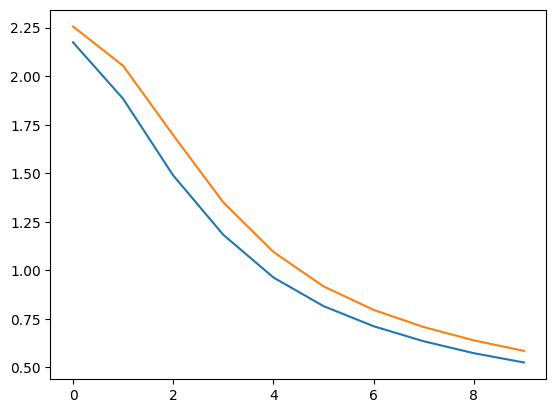

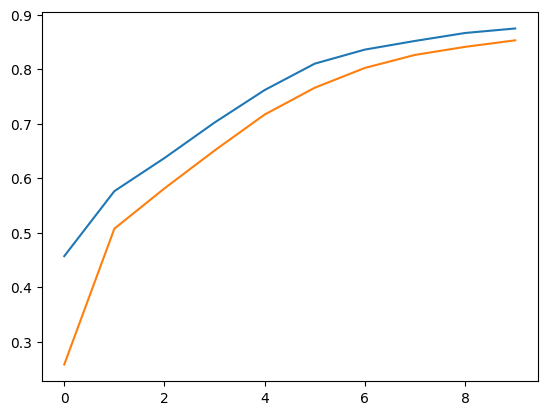

In [ ]:
from matplotlib import pyplot as plt

plt.plot(np.arange(10), history.history['val_loss'])
plt.plot(np.arange(10), history.history['loss'])
plt.show()
plt.plot(np.arange(10), history.history['val_accuracy'])
plt.plot(np.arange(10), history.history['accuracy'])
plt.show()